In [1]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg
# plotly
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import tensorflow as tf
from plotly.graph_objs import *
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

#This is for confusion_matrixes. We need to update mlxtend because this crap
# Has bug in it's default versuin 0.14. Probably 0.18 will work out
import mlxtend
                                                          
print(mlxtend.__version__) 

!pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

0.18.0
Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)
0.18.0


In [2]:
# original dataset folder, you can see above. 
# We are using this dataset already splitted into train and valid databsets because google drive and colab are very bad with each other.
input_path = Path('/content/drive/MyDrive/data')
flowers_path = input_path / 'valid'

In [3]:
# Each species of flower is contained in a separate folder. Get all the sub directories
# Only two from data dir - train and valid. TRAIN IS IN VALID AND VALID IS IN TRAIN!
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['sunflower', 'rose', 'tulip', 'daisy', 'dandelion']


In [4]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

category                                              image
0  sunflower  /content/drive/MyDrive/data/valid/sunflower/14...
1  sunflower  /content/drive/MyDrive/data/valid/sunflower/14...
2  sunflower  /content/drive/MyDrive/data/valid/sunflower/13...
3  sunflower  /content/drive/MyDrive/data/valid/sunflower/13...
4  sunflower  /content/drive/MyDrive/data/valid/sunflower/14...

In [5]:
flowers['image'][0]

'/content/drive/MyDrive/data/valid/sunflower/14925398441_107f3e0304_n.jpg'

In [6]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3856
Flowers in each category: 
dandelion    975
tulip        894
rose         684
daisy        669
sunflower    634
Name: category, dtype: int64


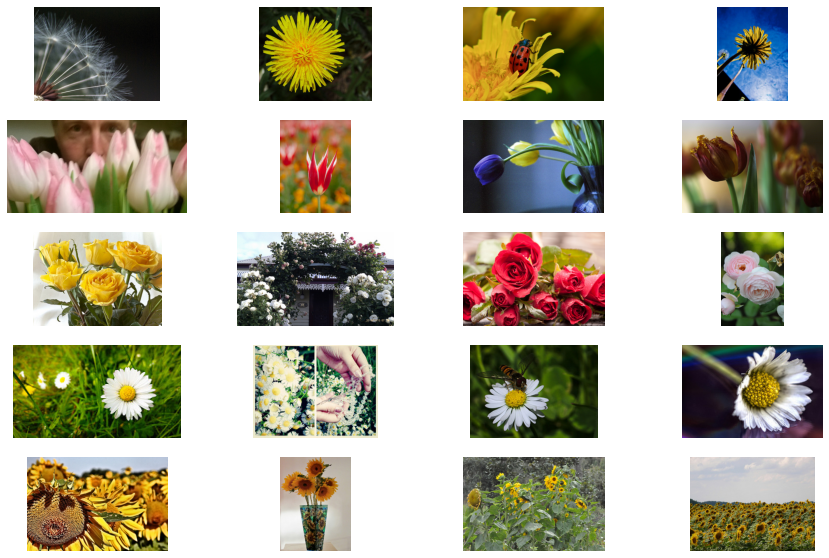

In [7]:
# Let's visualize some flowers from each category
# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show() 

In [8]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [10]:
base_dir = '/content/drive/MyDrive/data'
validation_dir = os.path.join(base_dir, 'train')
train_dir = os.path.join(base_dir, 'valid')

In [11]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
accuracies = []

In [12]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(240, 240),
        batch_size = batch_size, 
        class_mode='categorical')

    i = 0

    print('Entering for loop...');

    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_dir, 3853)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 3853 images belonging to 5 classes.
Entering for loop...
Found 500 images belonging to 5 classes.
Entering for loop...


In [14]:
train_features = np.reshape(train_features, (3853, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (500, 7 * 7 * 512))

# FROM SCRATCH

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(240, 240, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [17]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/train', 
        target_size=(240, 240),  
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical')

Found 500 images belonging to 5 classes.
Found 3853 images belonging to 5 classes.


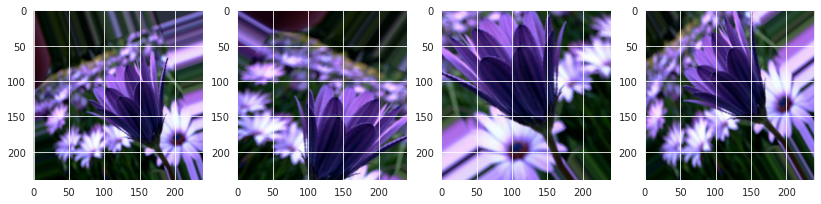

In [18]:
from keras.preprocessing import image
fnames = [os.path.join('/content/drive/MyDrive/data/train/daisy', fname) for
fname in os.listdir('/content/drive/MyDrive/data/train/daisy')]
img_path = fnames[22]
img = image.load_img(img_path, target_size=(240, 240))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
f, axes = plt.subplots(1,4,figsize=(14,4))
for batch in train_datagen.flow(x, batch_size=1):
    imgplot = axes[i].imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [20]:
history = model.fit_generator(
          train_generator,
          steps_per_epoch=15,
          epochs=50,
          validation_data=validation_generator,
          validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
15/15 [==============================] - 14s 950ms/step - loss: 1.5304 - acc: 0.3483 - val_loss: 1.4875 - val_acc: 0.2950
Epoch 2/50
15/15 [==============================] - 14s 946ms/step - loss: 1.4205 - acc: 0.3825 - val_loss: 1.4066 - val_acc: 0.3450
Epoch 3/50
15/15 [==============================] - 14s 936ms/step - loss: 1.3581 - acc: 0.3782 - val_loss: 1.2908 - val_acc: 0.4181
Epoch 4/50
15/15 [==============================] - 14s 948ms/step - loss: 1.2405 - acc: 0.4295 - val_loss: 1.2645 - val_acc: 0.3994
Epoch 5/50
15/15 [==============================] - 14s 946ms/step - loss: 1.2017 - acc: 0.4530 - val_loss: 1.3056 - val_acc: 0.4269
Epoch 6/50
15/15 [==============================] - 14s 945ms/step - loss: 1.2060 - acc: 0.4509 - val_loss: 1.2461 - val_acc: 0.4350
Epoch 7/50
15/15 [==============================] - 14s 932ms/step - loss: 1.1762 - acc: 0.4594 - val_loss: 1.3029 - val_acc: 0.3844
Epoch 8/50
15/15 [==============================] - 14s 940ms/step - 

In [21]:
model.save('flowers_recognition_v2.h5')

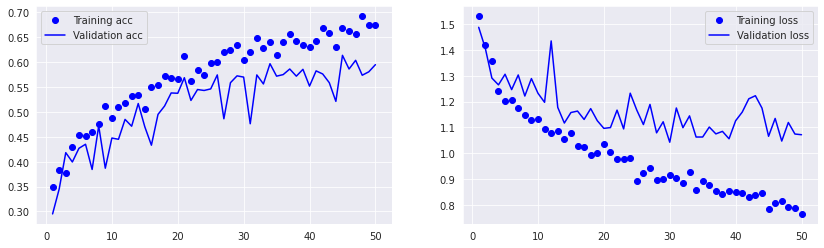

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [23]:
model_0_val = val_acc[-1]
accuracies.append(model_0_val)
print("Validation Accuracy: ", model_0_val)

Validation Accuracy:  0.5950000286102295


# FE WITHOUD DA VGG

In [24]:
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [27]:
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

Epoch 1/25
241/241 [==============================] - 7s 26ms/step - loss: 2.0297 - acc: 0.2956 - val_loss: 1.0933 - val_acc: 0.6320
Epoch 2/25
241/241 [==============================] - 6s 25ms/step - loss: 1.2719 - acc: 0.4985 - val_loss: 0.9232 - val_acc: 0.6480
Epoch 3/25
241/241 [==============================] - 6s 25ms/step - loss: 1.0243 - acc: 0.6017 - val_loss: 0.7746 - val_acc: 0.7100
Epoch 4/25
241/241 [==============================] - 6s 25ms/step - loss: 0.8359 - acc: 0.6927 - val_loss: 0.7027 - val_acc: 0.7260
Epoch 5/25
241/241 [==============================] - 6s 25ms/step - loss: 0.6998 - acc: 0.7404 - val_loss: 0.6565 - val_acc: 0.7520
Epoch 6/25
241/241 [==============================] - 6s 25ms/step - loss: 0.6447 - acc: 0.7793 - val_loss: 0.6588 - val_acc: 0.7600
Epoch 7/25
241/241 [==============================] - 6s 25ms/step - loss: 0.5112 - acc: 0.8288 - val_loss: 0.7593 - val_acc: 0.7500
Epoch 8/25
241/241 [==============================] - 6s 25ms/step - 

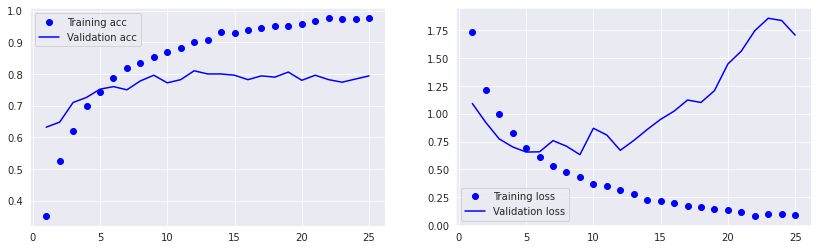

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [29]:
model_1_val = val_acc[-1]
accuracies.append(model_1_val)
print("Validation Accuracy: ", model_1_val)

Validation Accuracy:  0.7940000295639038


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0bd83af590>)

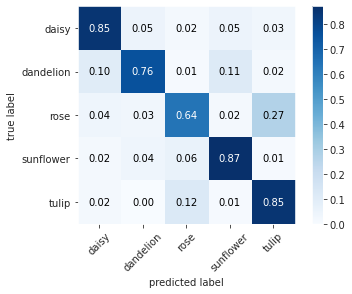

In [30]:
from mlxtend.plotting import plot_confusion_matrix
y_pred=model.predict_classes(validation_features)
con_mat = tf.math.confusion_matrix(validation_labels.argmax(1), y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],colorbar=True,
                                show_absolute=False,
                                show_normed=True)

The model has overfitting problem. The accuracy is about %80. However, using data augmentation is one of the ways to prevent overfitting. Let's try augmentation and see the improvement

# WITH DA VGG

In [31]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [33]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 500 images belonging to 5 classes.
Found 3853 images belonging to 5 classes.


In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [35]:
history = model.fit_generator(
          train_generator,
          epochs=30,
          validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
16/16 [==============================] - 38s 2s/step - loss: 1.9109 - acc: 0.2218 - val_loss: 1.5899 - val_acc: 0.2146
Epoch 2/30
16/16 [==============================] - 30s 2s/step - loss: 1.6947 - acc: 0.2132 - val_loss: 1.5031 - val_acc: 0.4015
Epoch 3/30
16/16 [==============================] - 30s 2s/step - loss: 1.5081 - acc: 0.3314 - val_loss: 1.3813 - val_acc: 0.5110
Epoch 4/30
16/16 [==============================] - 30s 2s/step - loss: 1.3687 - acc: 0.4219 - val_loss: 1.2313 - val_acc: 0.5219
Epoch 5/30
16/16 [==============================] - 30s 2s/step - loss: 1.2134 - acc: 0.4911 - val_loss: 1.0450 - val_acc: 0.6055
Epoch 6/30
16/16 [==============================] - 30s 2s/step - loss: 1.0949 - acc: 0.5366 - val_loss: 1.0728 - val_acc: 0.6060
Epoch 7/30
16/16 [==============================] - 30s 2s/step - loss: 0.8974 - acc: 0.6622 - val_loss: 0.9660 - val_acc: 0.6372
Epoch 8/30
16/16 [==============================] - 30s 2s/step - loss: 0.7959 - acc: 0.68

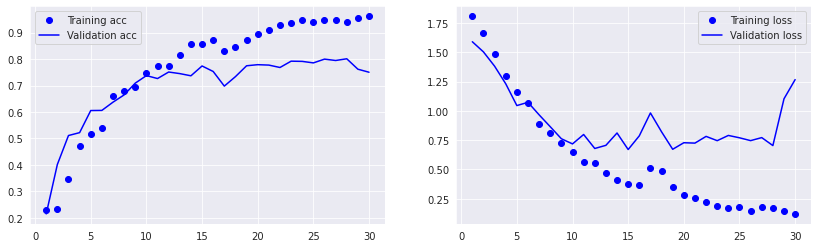

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

The model is overfitting, but the accuracy is pretty good!

In [37]:
model_2_val = val_acc[-1]
accuracies.append(model_2_val)
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.7503244280815125


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0b36122bd0>)

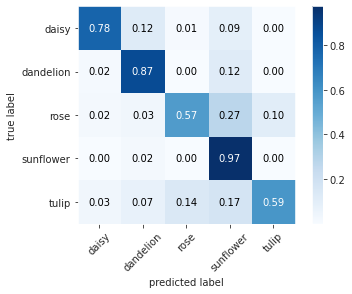

In [38]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = validation_generator.class_indices.keys(),colorbar=True,
                                show_absolute=False,
                                show_normed=True)

# Fine Tuning 

In [39]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [40]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [41]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [42]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
15/15 [==============================] - 17s 1s/step - loss: 0.3839 - acc: 0.9698 - val_loss: 0.1923 - val_acc: 0.8169
Epoch 2/30
15/15 [==============================] - 16s 1s/step - loss: 0.1238 - acc: 0.9203 - val_loss: 0.1478 - val_acc: 0.8719
Epoch 3/30
15/15 [==============================] - 16s 1s/step - loss: 0.1030 - acc: 0.9604 - val_loss: 0.1957 - val_acc: 0.8269
Epoch 4/30
15/15 [==============================] - 16s 1s/step - loss: 0.0741 - acc: 0.9653 - val_loss: 0.1714 - val_acc: 0.8544
Epoch 5/30
15/15 [==============================] - 16s 1s/step - loss: 0.0765 - acc: 0.9695 - val_loss: 0.1608 - val_acc: 0.8712
Epoch 6/30
15/15 [==============================] - 16s 1s/step - loss: 0.0555 - acc: 0.9876 - val_loss: 0.1845 - val_acc: 0.8569
Epoch 7/30
15/15 [==============================] - 16s 1s/step - loss: 0.0565 - acc: 0.9659 - val_loss: 0.1660 - val_acc: 0.8800
Epoch 8/30
15/15 [==============================] - 16s 1s/step - loss: 0.0459 - acc: 0.98

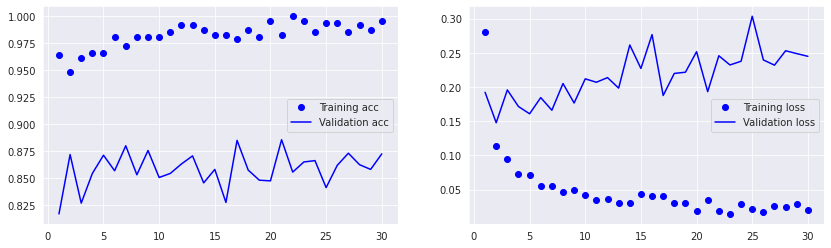

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [44]:
model_3_val = val_acc[-1]
accuracies.append(model_3_val)
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.8725000023841858


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0b22432790>)

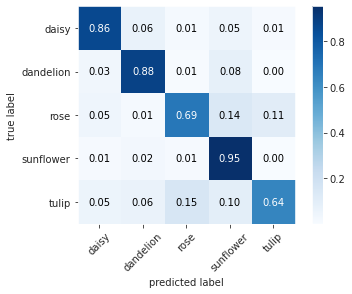

In [45]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(conf_mat = con_mat, class_names = validation_generator.class_indices.keys(),colorbar=True,
                                show_absolute=False,
                                show_normed=True)

4


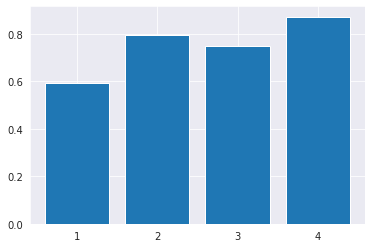

0.5950000286102295
0.7940000295639038
0.7503244280815125
0.8725000023841858


In [46]:
# plotting by columns
print(len(accuracies))
labels = ['1','2','3','4']

plt.bar([1,2,3,4], accuracies, tick_label = labels,
        width = 0.8)
plt.show()

for i in accuracies:
  print(i)

# FILTER SHOWDOWN + LAYERS + PCA + ETC.

In [47]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))
res = []
for i in range(len(conv_base.layers)):
	layer = conv_base.layers[i]
	if 'conv' not in layer.name:
		continue
	res = res + [[i, int(layer.output.shape[1])]]
print(res)

[[1, 240], [2, 240], [4, 120], [5, 120], [7, 60], [8, 60], [9, 60], [11, 30], [12, 30], [13, 30], [15, 15], [16, 15], [17, 15]]


In [48]:
from keras.applications.vgg16 import preprocess_input
from numpy import expand_dims
from keras.models import Model
from matplotlib import pyplot
def plot_layers(conv_base, i, size):
    img = load_img('/content/drive/MyDrive/data/train/rose/16643785404_284c6c23fe_n.jpg', target_size=(240, 240))
    img = img_to_array(img)
    img = expand_dims(img, axis=0)
    img = preprocess_input(img)
    pyplot.figure(figsize=(19, 14))
    model = Model(inputs=conv_base.inputs, outputs=conv_base.layers[i].output)
    feature_maps = model.predict(img)
    square = 8
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    pyplot.show()

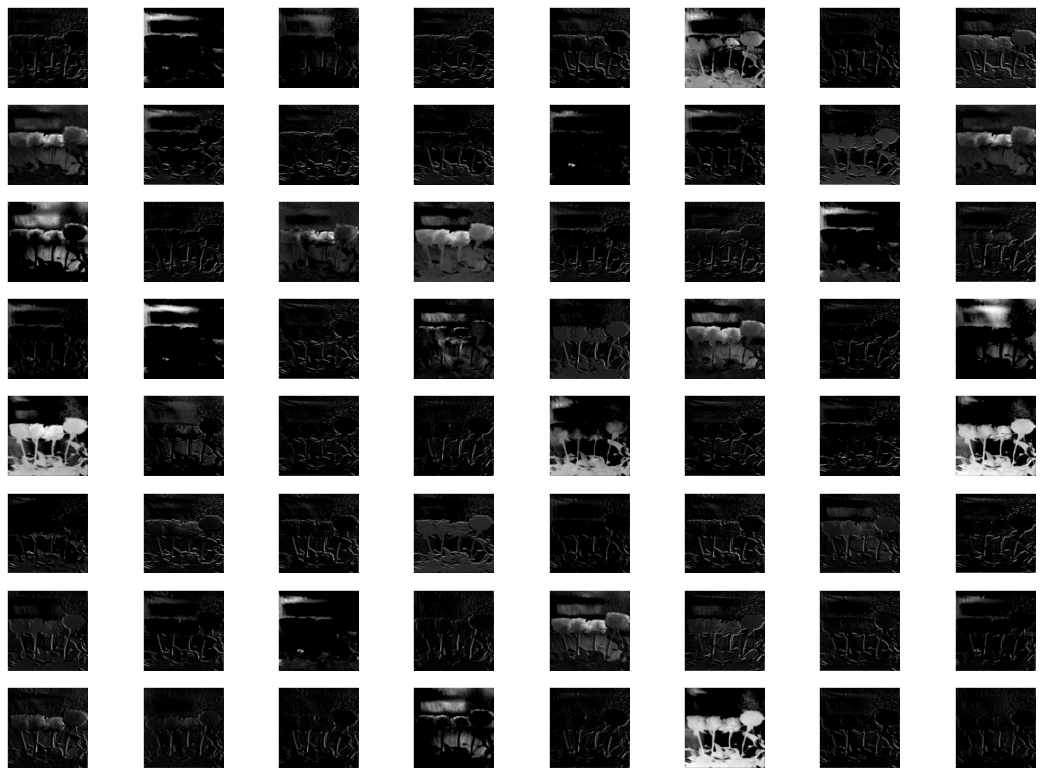

Layer 0


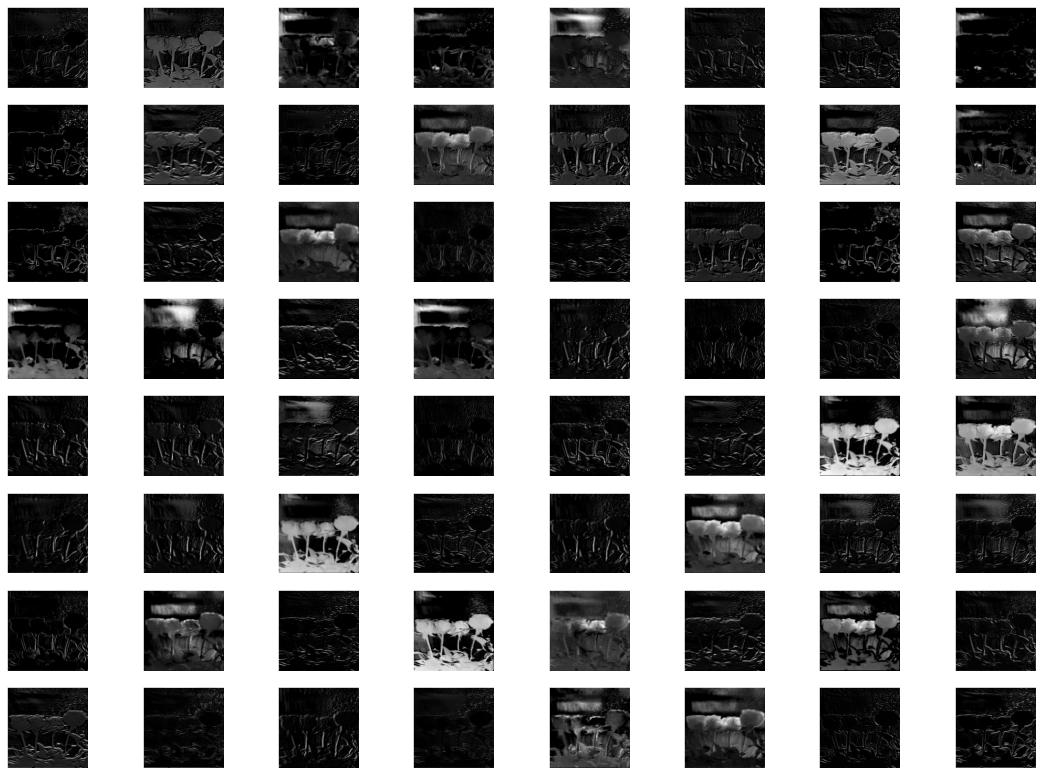

Layer 1


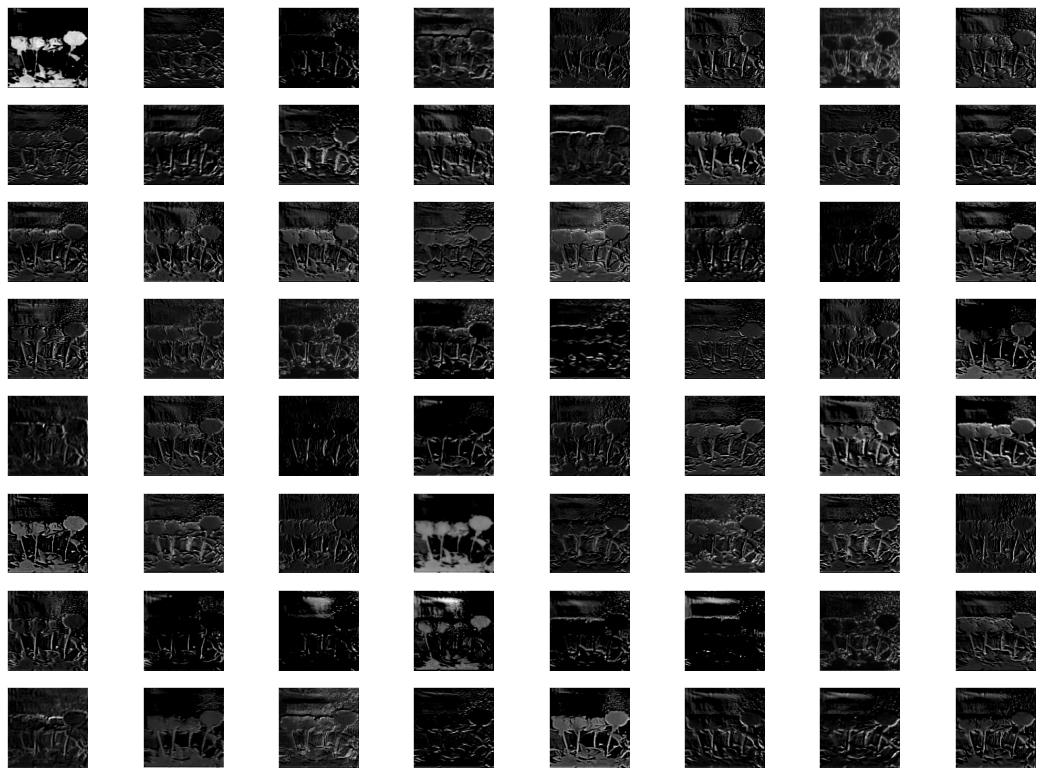

Layer 2


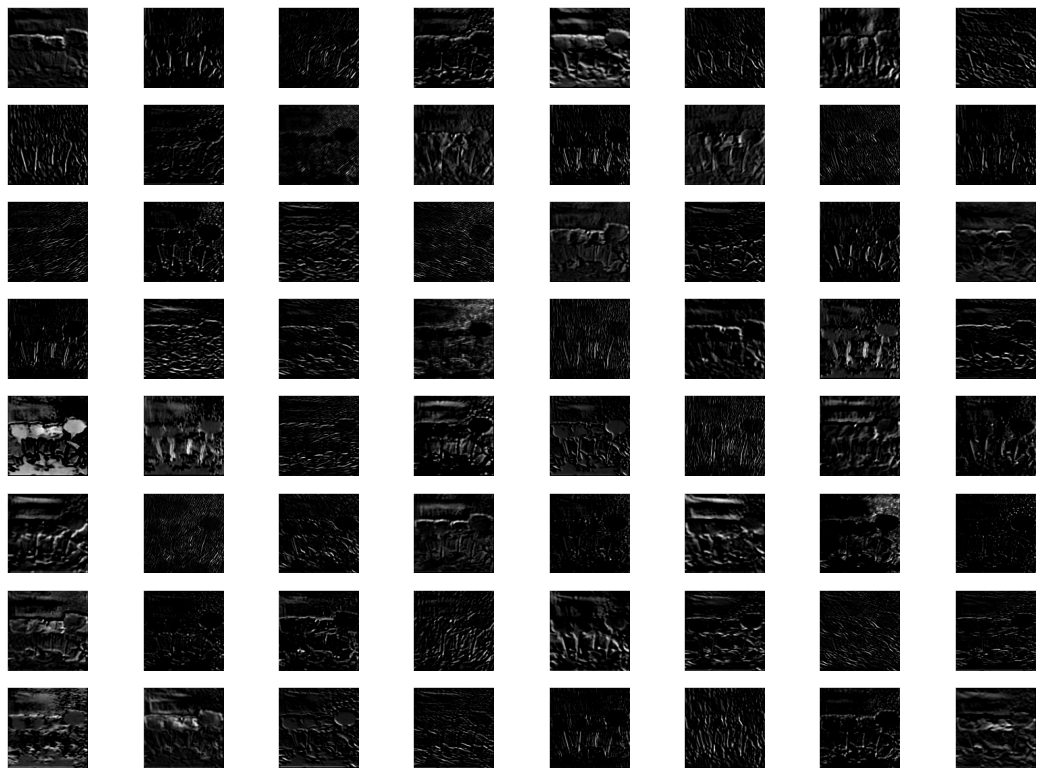

Layer 3


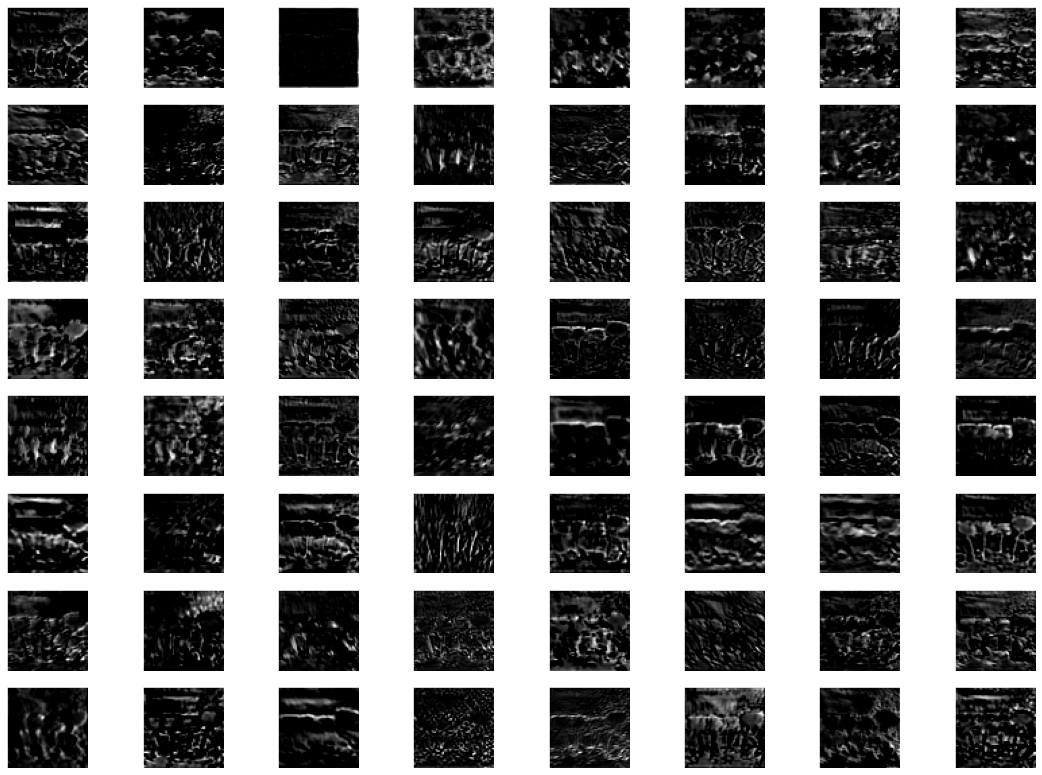

Layer 4


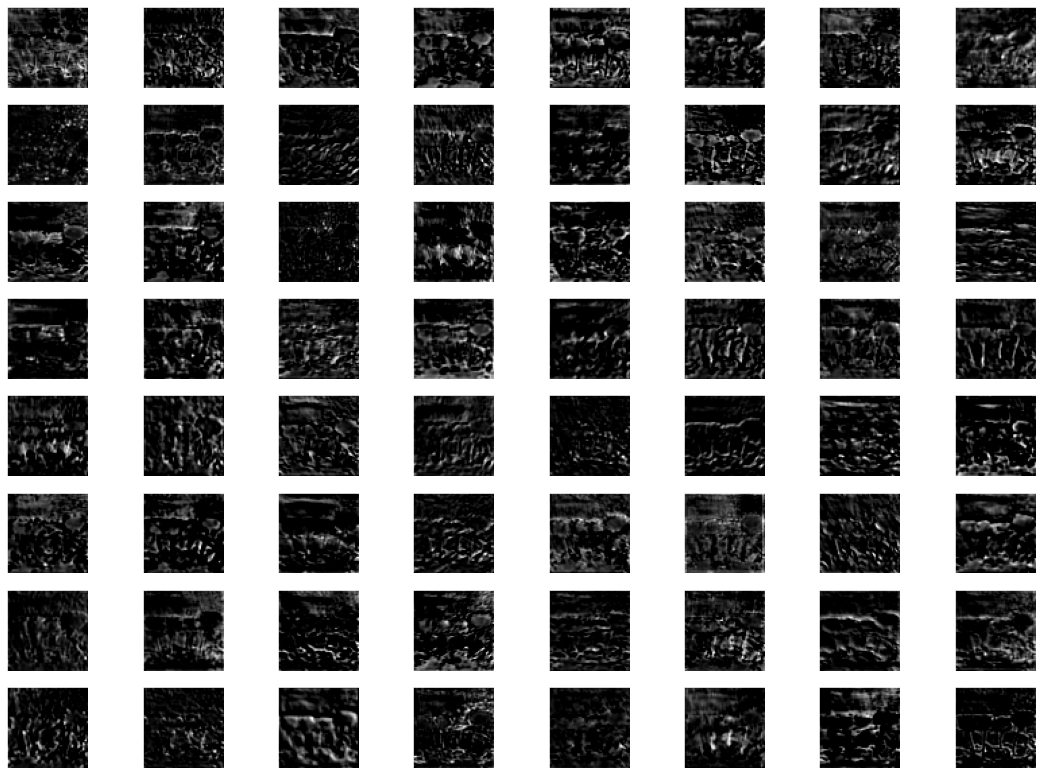

Layer 5


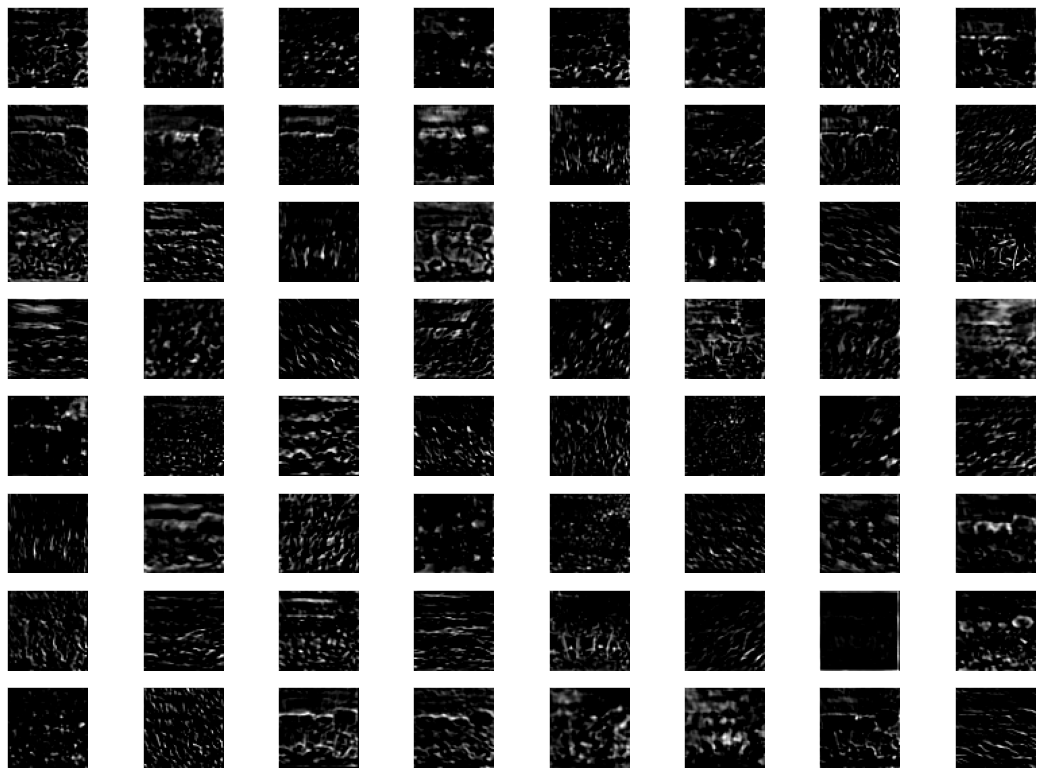

Layer 6


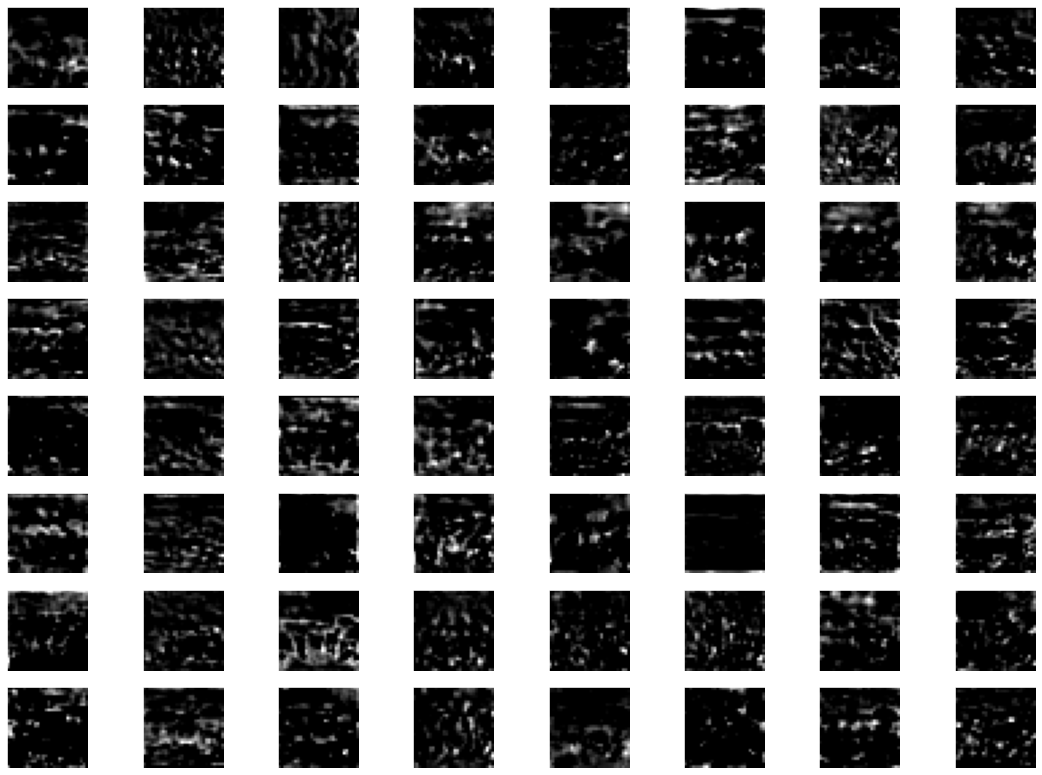

Layer 7


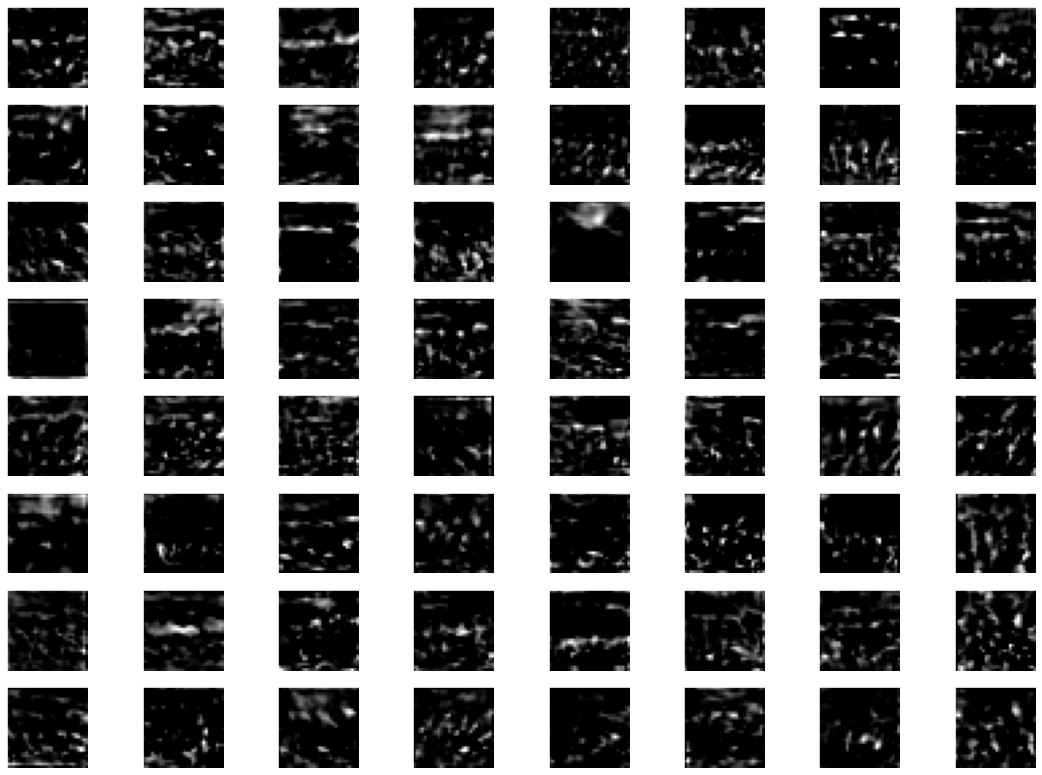

Layer 8


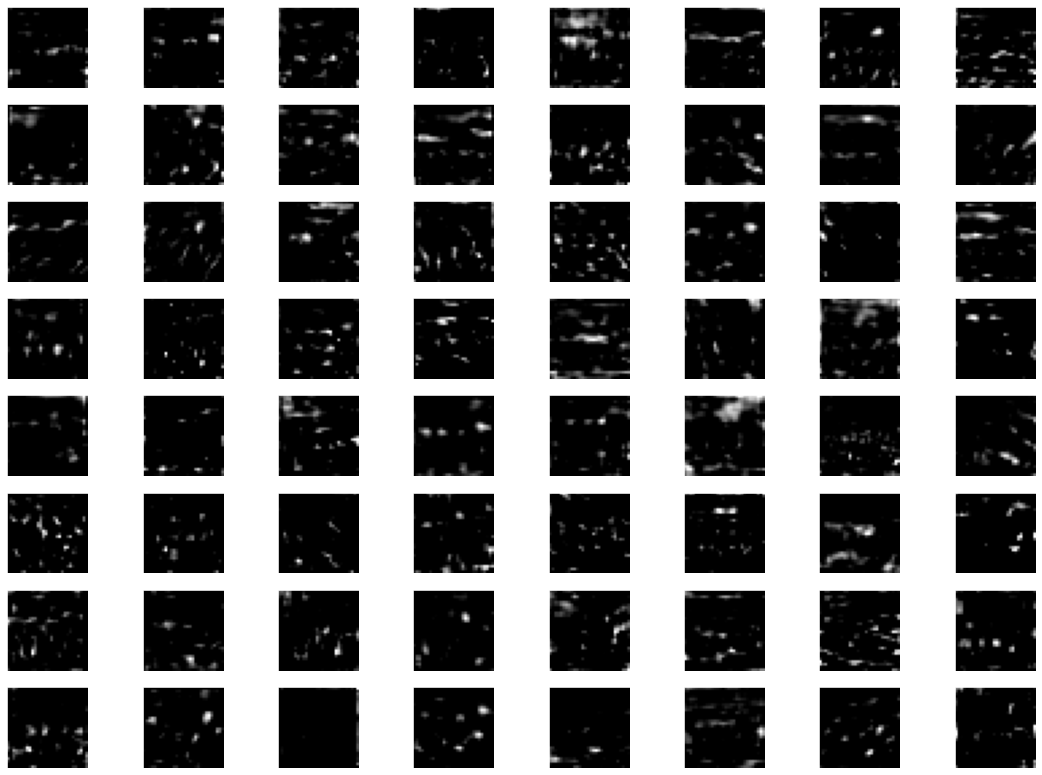

Layer 9


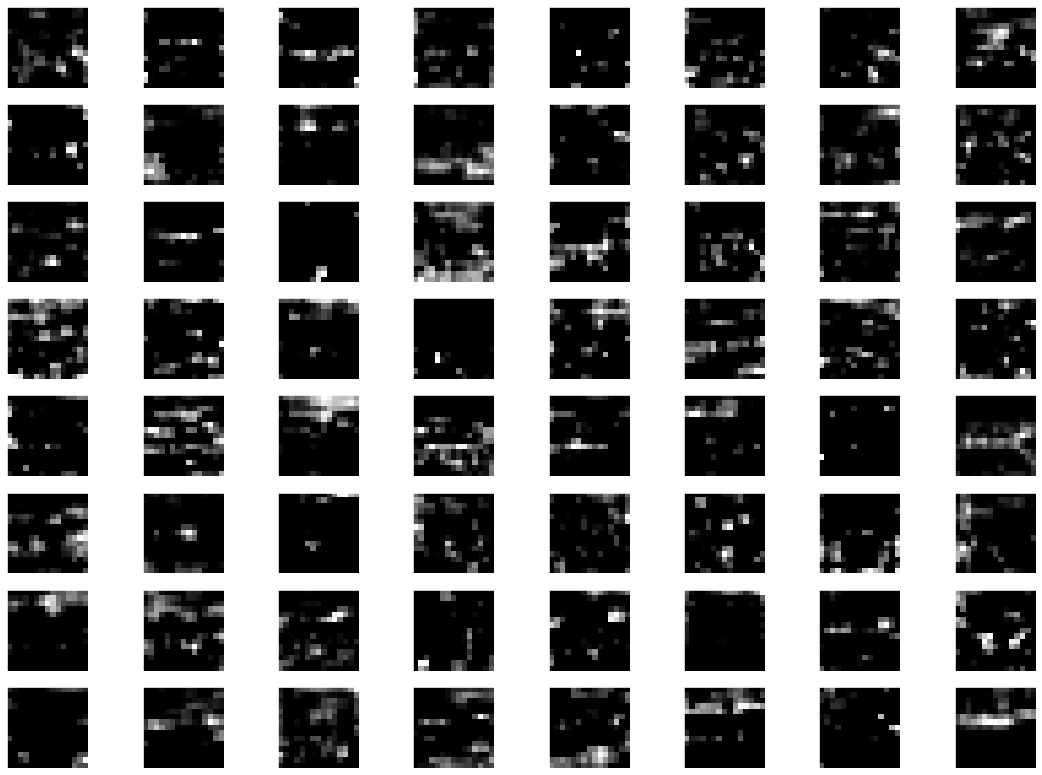

Layer 10


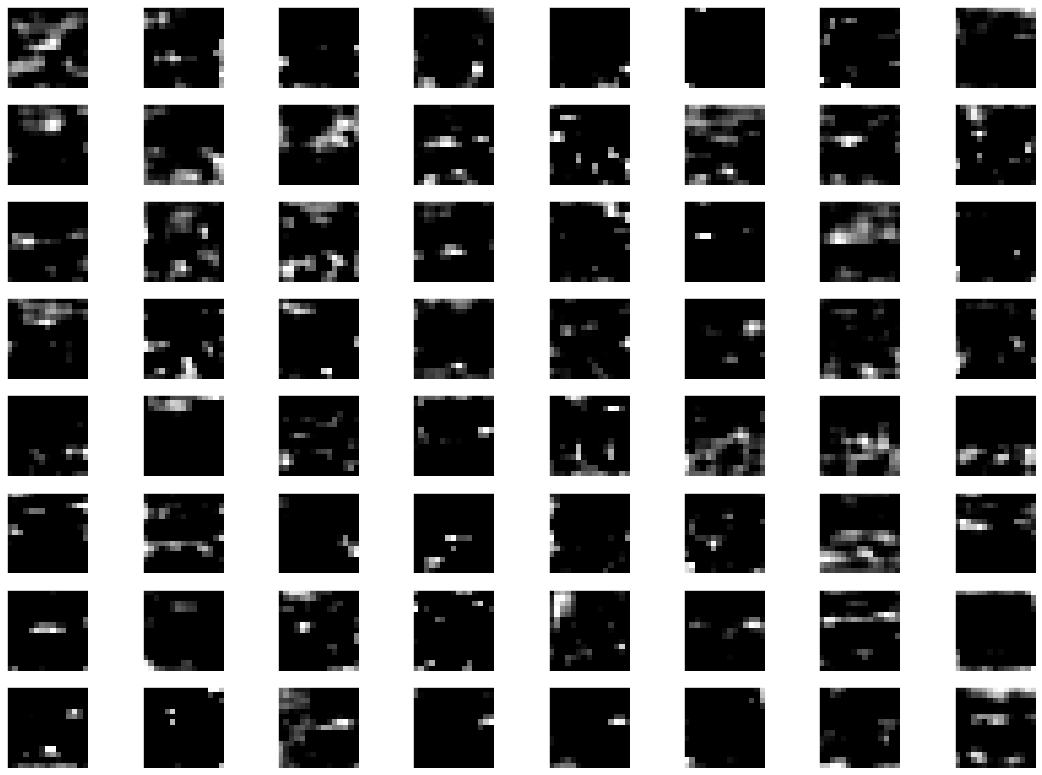

Layer 11


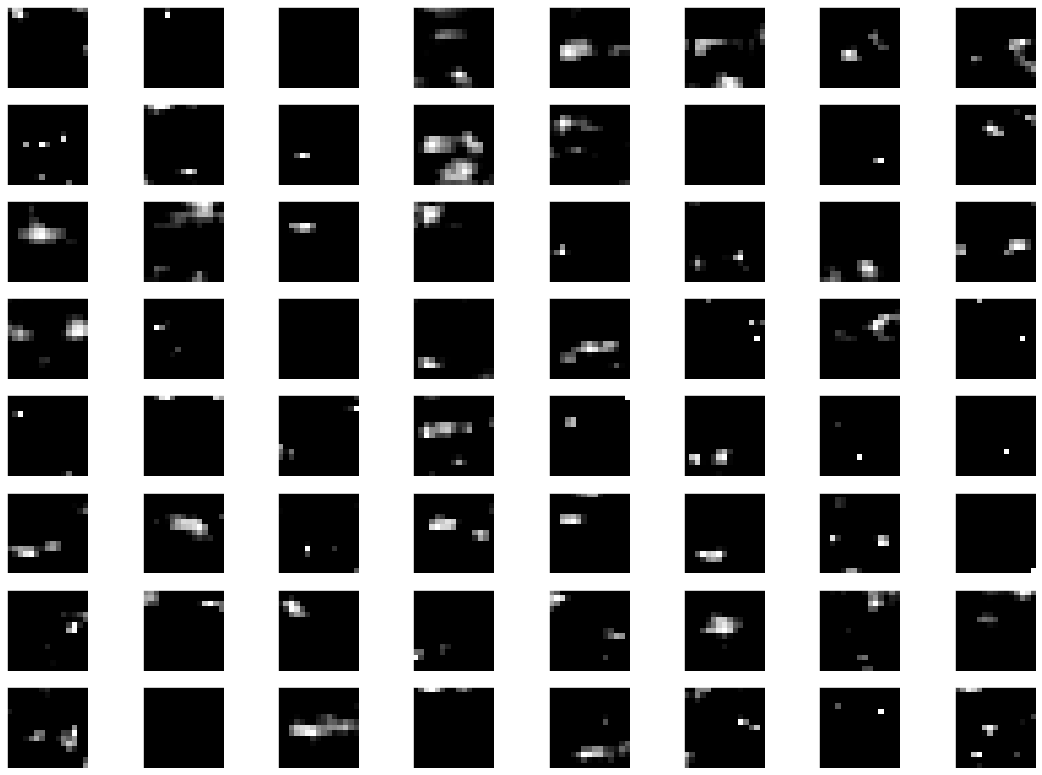

Layer 12


In [49]:
for i in range(0, len(res)):
    plot_layers(conv_base, res[i][0], res[i][1])
    print("Layer",i)

In [50]:
to_show = []
for i in range(len(conv_base.layers)):
    layer = conv_base.layers[i]
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(i, filters.shape)
    to_show = to_show + [i]

1 (3, 3, 3, 64)
2 (3, 3, 64, 64)
4 (3, 3, 64, 128)
5 (3, 3, 128, 128)
7 (3, 3, 128, 256)
8 (3, 3, 256, 256)
9 (3, 3, 256, 256)
11 (3, 3, 256, 512)
12 (3, 3, 512, 512)
13 (3, 3, 512, 512)
15 (3, 3, 512, 512)
16 (3, 3, 512, 512)
17 (3, 3, 512, 512)


In [51]:
def plot_filters(n):
    filters, _ = conv_base.layers[n].get_weights()
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 6, 1
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(3):
            # specify subplot and turn of axis
            ax = pyplot.subplot(n_filters, 3, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(f[:, :, j], cmap= "gray")
            ix += 1   

    pyplot.show()

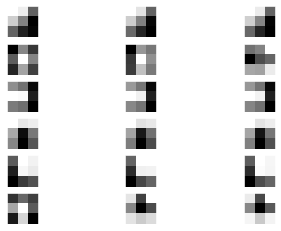

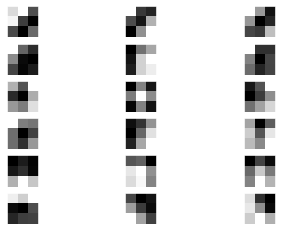

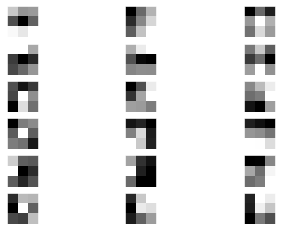

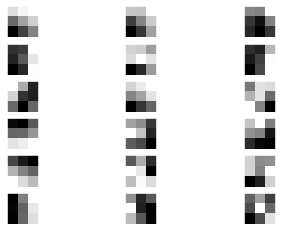

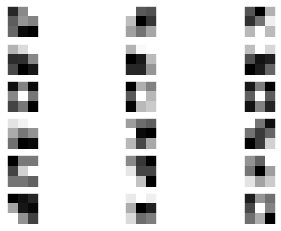

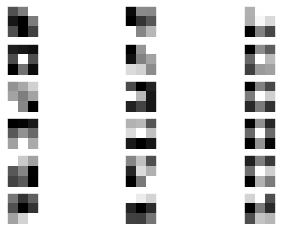

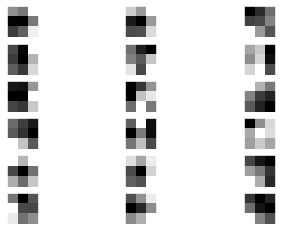

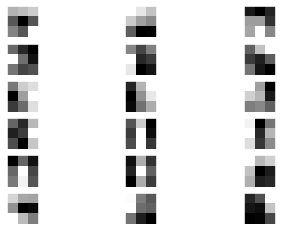

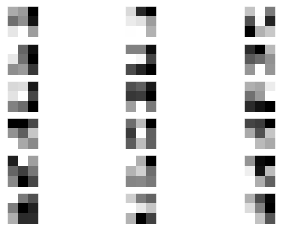

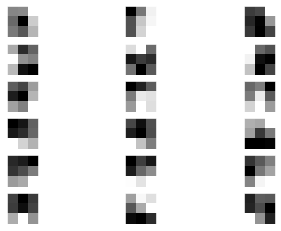

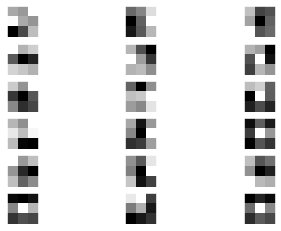

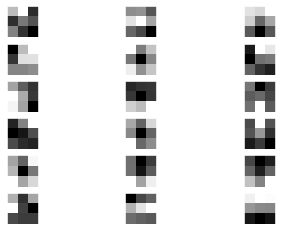

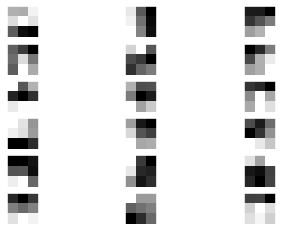

In [52]:
for i in range(0, len(to_show)):
    plot_filters(to_show[i])

In [53]:
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K

print(K.image_data_format())


def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        s_time = time.time()

        loss = K.mean(layer_output[:, :, :, filter_index])

        grads = K.gradients(loss, input_img)[0]

        grads = normalize(grads)

        iterate = K.function([input_img], [loss, grads])

        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
       
        input_img_data = np.random.random((1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        for up in reversed(range(upscaling_steps)):
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                if loss_value <= K.epsilon():
                    return None

            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    _draw_filters(processed_filters)

LAYER_NAME = 'block5_conv1'

vgg = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')
vgg.summary()

channels_last
Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

In [ ]:
tf.compat.v1.disable_eager_execution()
visualize_layer(vgg, LAYER_NAME)

Compute filters 0 to 512
Costs of filter   0:   408 ( 10.61s )
Costs of filter   2:   413 ( 2.07s )
Costs of filter   3:   517 ( 2.09s )
Costs of filter   4:   601 ( 2.07s )
Costs of filter   5:   522 ( 2.10s )
Costs of filter   7:   966 ( 2.08s )
Costs of filter   8:   885 ( 2.13s )
Costs of filter   9:   482 ( 2.11s )
Costs of filter  10:   547 ( 2.10s )
Costs of filter  11:   753 ( 2.13s )
Costs of filter  13:   360 ( 2.15s )
Costs of filter  14:   692 ( 2.14s )
Costs of filter  15:   527 ( 2.14s )
Costs of filter  17:   832 ( 2.15s )
Costs of filter  20:   528 ( 2.16s )
Costs of filter  22:   601 ( 2.19s )
Costs of filter  24:   452 ( 2.16s )
Costs of filter  25:   564 ( 2.19s )
Costs of filter  27:   870 ( 2.20s )
Costs of filter  28:   560 ( 2.19s )
Costs of filter  29:   528 ( 2.20s )
Costs of filter  30:   604 ( 2.22s )
Costs of filter  31:   386 ( 2.25s )
Costs of filter  32:   389 ( 2.22s )
Costs of filter  34:   511 ( 2.23s )
Costs of filter  36:   859 ( 2.24s )
Costs of fil

# Showing our selected picture for PCA chart

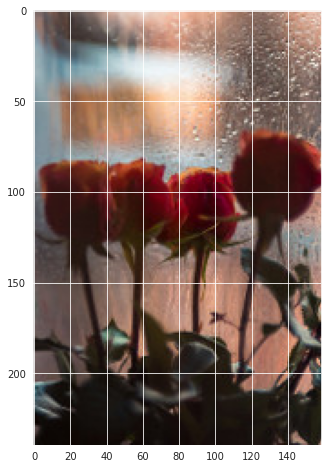

In [54]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

img = imread('/content/drive/MyDrive/data/train/rose/16643785404_284c6c23fe_n.jpg')

plt.figure(figsize=[12,8])
plt.imshow(img)

This is a colored image of a random selected flower from our dataset, that was used in previous algorith.
We will plot the matrix as a greyscale image

(240, 159)
1.0


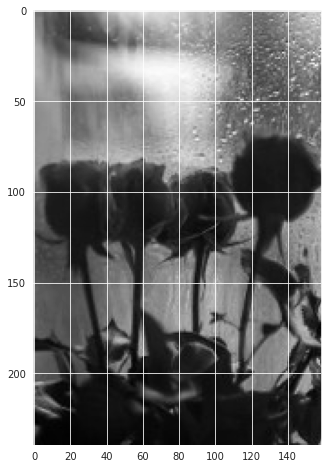

In [55]:
img_sum = img.sum(axis=2)
print(img_sum.shape)

img_bw = img_sum / img_sum.max()
print(img_bw.max())

plt.figure(figsize=[12,8])
plt.imshow(img_bw, cmap=plt.cm.gray)

**Performing PCA on the image**


*   We'll perform PCA on the matrix with all the components
*   We'll then look at the scree-plot to assess how many components we could retain and how much cumulative variance they capture
*   We'll pick a suitable number of components to represent the image for compression





Number of components explaining 95% variance: 12


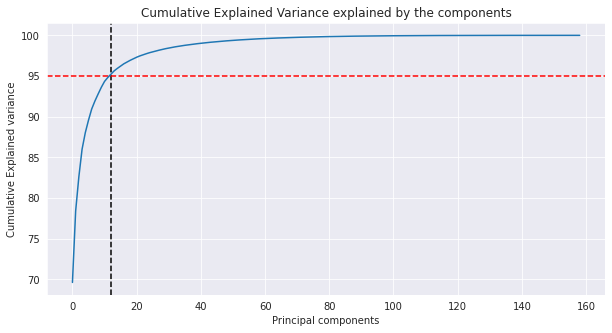

In [56]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np
pca = PCA()
pca.fit(img_bw)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

12 components out of 280 pixels  can explain 95% of the variance in the image. WOW!

# Reconstructing the b/w image with the limited number of components

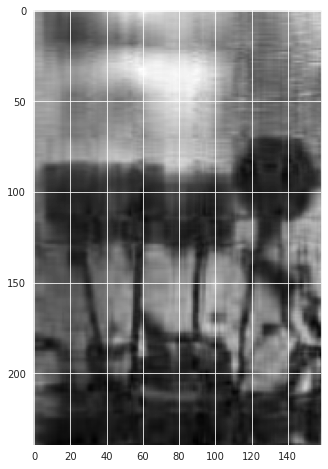

In [57]:
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(img_bw))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

1. First, we'll use the fit_transform method from the IncrementalPCA module to first find the 12 PCs and transform and represent the data in those 12 new components/columns.

2. Next, we'll reconstruct the original matrix from these 12 components using the inverse_transform method.

3. We'll then plot the image to visually assess the quality of it.

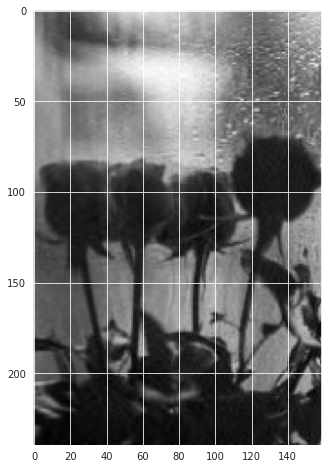

In [58]:
# Function to reconstruct and plot image for a given number of components

def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(img_bw))
    plt.imshow(image_recon,cmap = plt.cm.gray)
    

k = 50
plt.figure(figsize=[12,8])
plot_at_k(50)

# Reconstructing and plotting for different number of components

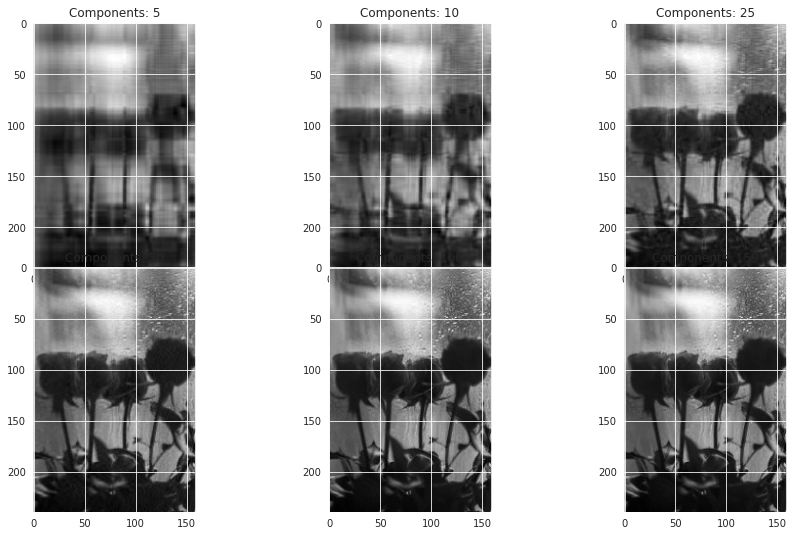

In [59]:
ks = [5, 10, 25, 50, 100, 159]

plt.figure(figsize=[15,9])

for i in range(6):
    plt.subplot(2,3,i+1)
    plot_at_k(ks[i])
    plt.title("Components: "+str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()